Case Study: Case Study: Sentiment Analysis on a set of Movie Reviews using Deep 
Learning techniques

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

In [2]:
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re, string, unicodedata
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense,Input,Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D,Bidirectional, Flatten, BatchNormalization, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import transformers

In [4]:
data=pd.read_csv('D:/notes/SEM 3/SNA/IMDB Dataset.csv')
M_R = data.copy()
M_R.head()


review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [5]:
M_R.describe()


review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

In [6]:
print(M_R['sentiment'].dtype)

object


In [7]:
M_R['sentiment'] = M_R['sentiment'].astype('category')

In [8]:
print(M_R['sentiment'].head())

0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: category
Categories (2, object): ['negative', 'positive']


In [9]:
print(M_R['sentiment'].isnull().sum())


0


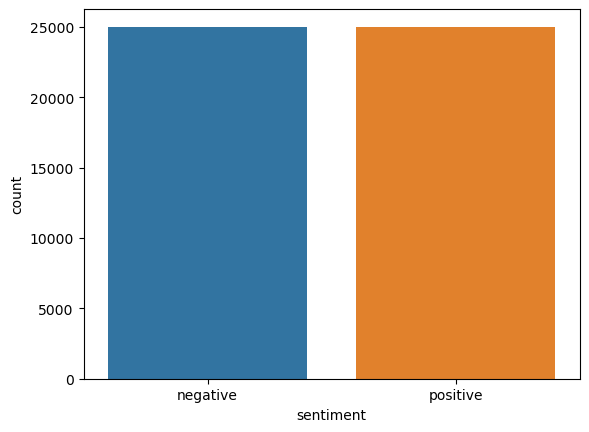

In [10]:
#sns.set_style('darkgrid')
sns.countplot(data=M_R, x='sentiment')
plt.show()

In [11]:
M_R.isna().sum()

review       0
sentiment    0
dtype: int64

In [12]:
M_R.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   review     50000 non-null  object  
 1   sentiment  50000 non-null  category
dtypes: category(1), object(1)
memory usage: 439.7+ KB


In [13]:
num_duplicates = M_R.duplicated().sum()
print("There are {} duplicate reviews present in the dataset".format(num_duplicates))

There are 418 duplicate reviews present in the dataset


In [14]:
review = M_R['review']
duplicated_review = M_R[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

review sentiment
34058  "Go Fish" garnered Rose Troche rightly or wron...  negative
47467  "Go Fish" garnered Rose Troche rightly or wron...  negative
29956  "Three" is a seriously dumb shipwreck movie. M...  negative
31488  "Three" is a seriously dumb shipwreck movie. M...  negative
47527  "Witchery" might just be the most incoherent a...  negative

In [15]:
stop = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stop.update(punctuations)

In [16]:
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

#sample_text = nltk.word_tokenize(sample_text)

[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [17]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


In [18]:
def remove_square_brackets_and_urls(text):
    text = re.sub('\[[^]]*\]', '', text)  # Remove square brackets
    text = re.sub(r'http\S+', '', text)    # Remove URLs
    return text

In [19]:
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

In [20]:
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_square_brackets_and_urls(text)
    text = remove_stopwords(text)
    return text

In [21]:
M_R['review'] = M_R['review'].apply(denoise_text)
M_R.head()

review sentiment
0  one reviewers mentioned watching oz episode ex...  positive
1  wonderful little filming technique fashion giv...  positive
2  thought wonderful way spend time hot summer si...  positive
3  basically family little boy thinks zombie clos...  negative
4  petter time visually stunning film mattei offe...  positive

In [22]:
M_R.sentiment.replace("positive",1,inplace=True)
M_R.sentiment.replace("negative",0,inplace=True)

M_R.head(10)

review sentiment
0  one reviewers mentioned watching oz episode ex...         1
1  wonderful little filming technique fashion giv...         1
2  thought wonderful way spend time hot summer si...         1
3  basically family little boy thinks zombie clos...         0
4  petter time visually stunning film mattei offe...         1
5  probably favorite story sacrifice dedication n...         1
6  sure would like see resurrection dated seahunt...         1
7  show fresh innovative idea first first years t...         0
8  encouraged positive comments film looking forw...         0
9  like original gut wrenching laughter like youn...         1

In [23]:
sns.set_style("whitegrid")

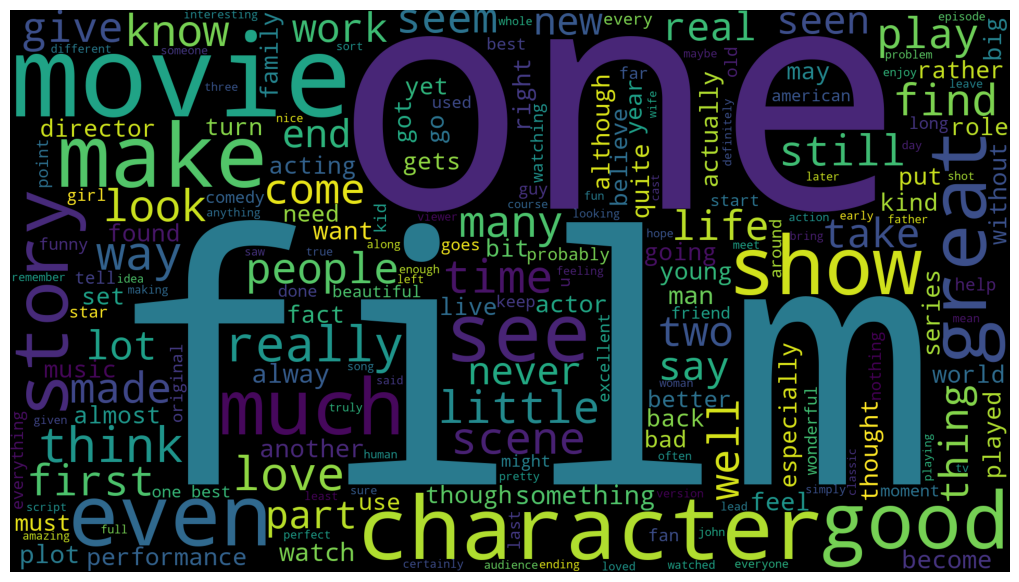

In [24]:
wordcloud = WordCloud(width=1920,height=1080).generate(" ".join(M_R[M_R.sentiment==1].review))
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

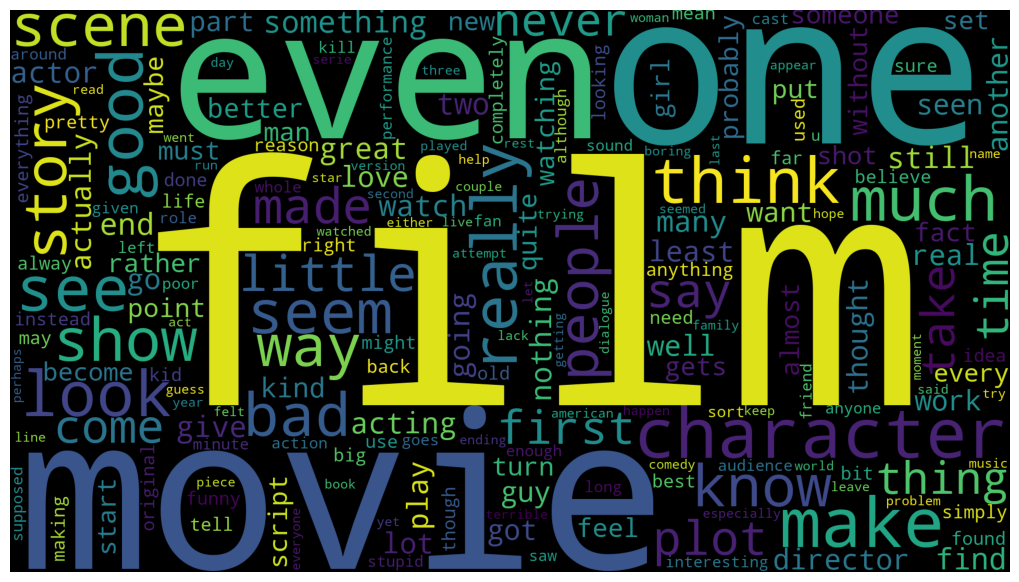

In [25]:
wordcloud = WordCloud(width=1920,height=1080).generate(" ".join(M_R[M_R.sentiment==0].review))
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


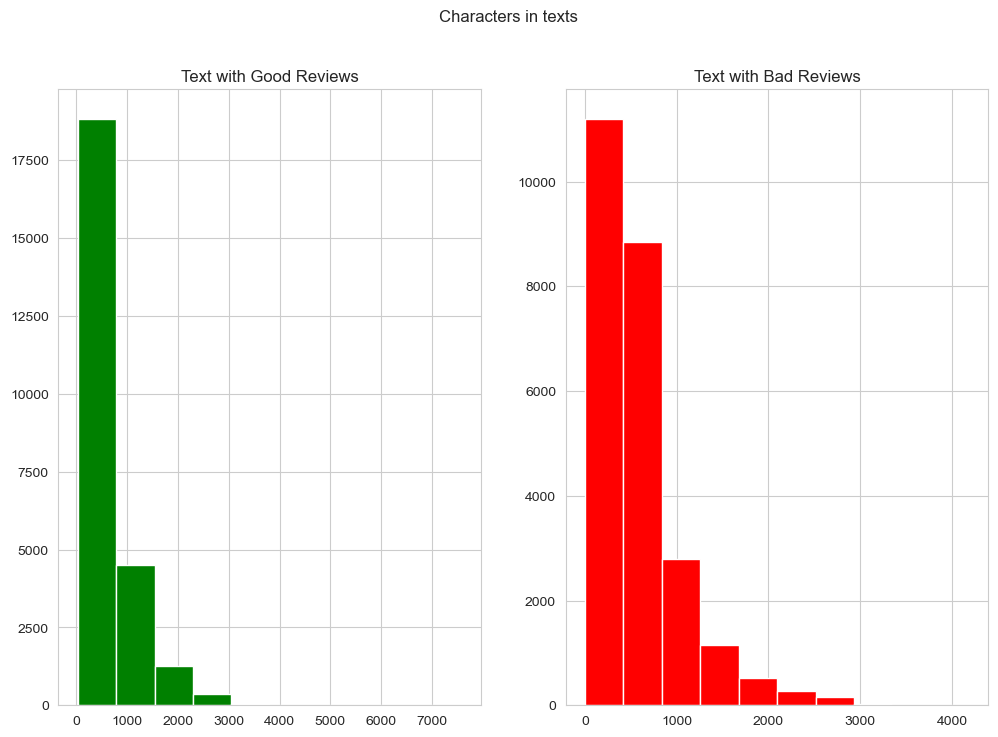

In [26]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=M_R[M_R['sentiment']==1]['review'].str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Text with Good Reviews')
text_len=M_R[M_R['sentiment']==0]['review'].str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Characters in texts')
plt.show()

In [27]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(M_R.review)
corpus[:5]

['one', 'reviewers', 'mentioned', 'watching', 'oz']

In [28]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(20)
most_common = dict(most_common)
most_common

{'movie': 61492,
 'film': 55087,
 'one': 45065,
 'like': 37301,
 'would': 23813,
 'even': 23718,
 'good': 23475,
 'really': 21806,
 'see': 20905,
 'get': 17691,
 'much': 17293,
 'story': 16812,
 'also': 15773,
 'time': 15658,
 'great': 15475,
 'first': 15473,
 'people': 15033,
 'make': 15027,
 'could': 14928,
 'made': 13562}

In [29]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [30]:
most_common_uni = get_top_text_ngrams(M_R.review,20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words", "Count"])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words",title="Common Word in Text",orientation='h',width=700,height=700,color='Common_words')
fig.show()


In [31]:
most_common_bi = get_top_text_ngrams(M_R.review,20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words", "Count"])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words",title="Common Bigrams in Text",orientation='h',width=700,height=700,color='Common_words')
fig.show()

In [32]:
most_common_tri = get_top_text_ngrams(M_R.review,20,3)
most_common_tri = dict(most_common_tri)
temp = pd.DataFrame(columns = ["Common_words", "Count"])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())
fig = px.bar(temp, x="Count", y="Common_words",title="Common Trigrams in Text",orientation='h',width=700,height=700,color='Common_words')
fig.show()

In [33]:
train, test= train_test_split(M_R, test_size=0.2, random_state=42)
X_train, y_train = train['review'], train['sentiment']
X_test, y_test = test['review'], test['sentiment']


In [34]:
tfidf = TfidfVectorizer() #tfidfVectorizer
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


count_vect = CountVectorizer() # CountVectorizer
X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

Logistic Regression Accuracy:  87.73%

Logistic Regresion cross validation score:  87.00%


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4852
           1       0.89      0.87      0.88      5148

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



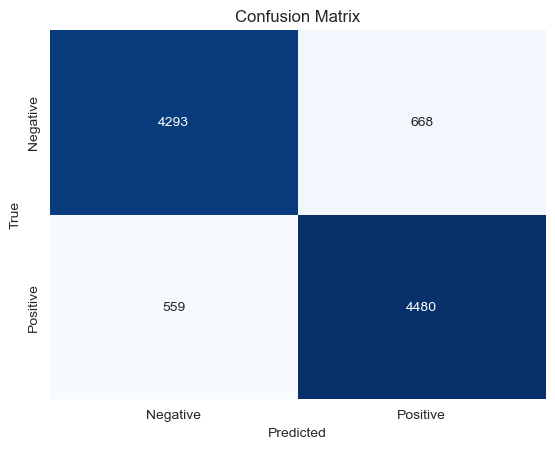

In [36]:
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
pred_lr = lr.predict(X_test_tfidf)
score_lr = accuracy_score(y_test, pred_lr)
lr_cvScore = cross_val_score(lr, X_train_tfidf, y_train, cv=5)
print("Logistic Regression Accuracy: ", "{:.2f}%".format(100*score_lr))
print("\nLogistic Regresion cross validation score: ","{:.2f}%".format(round(lr_cvScore.mean(),2)*100))
print("\n")
cm = confusion_matrix(y_test, pred_lr)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.grid(False)
print("Classification Report:\n")
print(classification_report(pred_lr,y_test))
plt.show()

In [42]:
df=pd.read_csv("D:/notes/SEM 3/SNA/data/test_data.csv") 
new_text=df['test']
# Preprocess the new text data
cleaned_new_text = [denoise_text(text) for text in new_text]

# Vectorize the new text data using the same vectorizer used during training
new_text_tfidf = tfidf.transform(cleaned_new_text)  # Use the same `tfidf` object from training

# Make predictions using the trained model
predictions = lr.predict(new_text_tfidf)  # Use the same `lr` object from training

# Print or use the predictions as needed
print(predictions)


[1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1]


Multinomial Naive Bayes Accuracy:  85.05%

Multinomial Naive Bayes cross validation score:  85.00%


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5070
           1       0.84      0.86      0.85      4930

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



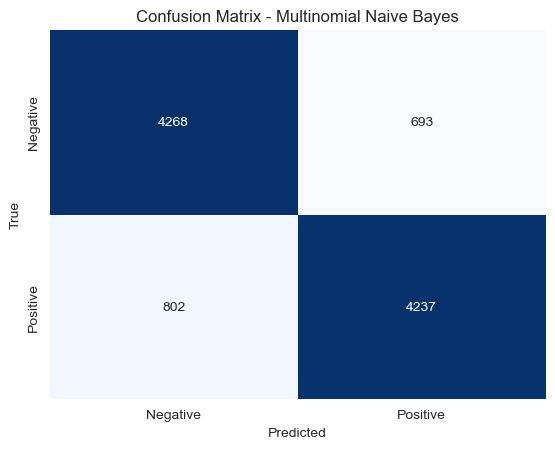

In [43]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
pred_mnb = mnb.predict(X_test_tfidf)
score_mnb = accuracy_score(y_test, pred_mnb)
mnb_cvScore = cross_val_score(mnb, X_train_tfidf, y_train, cv=5)
print("Multinomial Naive Bayes Accuracy: ", "{:.2f}%".format(100*score_mnb))
print("\nMultinomial Naive Bayes cross validation score: ","{:.2f}%".format(round(mnb_cvScore.mean(),2)*100))
print("\n")
print("Classification Report:\n")
print(classification_report(pred_mnb,y_test))
cm_mnb = confusion_matrix(y_test, pred_mnb)
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Multinomial Naive Bayes')
plt.show()


In [44]:
# Make predictions using the trained model
predictions = mnb.predict(new_text_tfidf)  # Use the same `lr` object from training

# Print or use the predictions as needed
print(predictions)

[0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1]


Linear Support Vectpr Classifier Accuracy:  87.72%

Linear Support Vector Classifier cross validation score:  88.00%


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4869
           1       0.89      0.87      0.88      5131

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



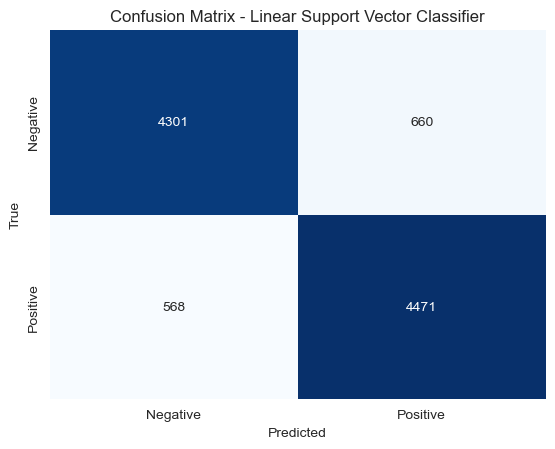

In [45]:
svc = LinearSVC(penalty='l2',loss='hinge')
svc.fit(X_train_tfidf, y_train)
pred_svc = svc.predict(X_test_tfidf)
score_svc = accuracy_score(y_test, pred_svc)
svc_cvScore = cross_val_score(svc, X_train_tfidf, y_train, cv=5)
print("Linear Support Vectpr Classifier Accuracy: ", "{:.2f}%".format(100*score_svc))
print("\nLinear Support Vector Classifier cross validation score: ","{:.2f}%".format(round(svc_cvScore.mean(),2)*100))
print("\n")
print("Classification Report:\n")
print(classification_report(pred_svc,y_test))
cm_svc = confusion_matrix(y_test, pred_svc)
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Linear Support Vector Classifier')
plt.show()


In [46]:
# Make predictions using the trained model
predictions = svc.predict(new_text_tfidf)  # Use the same `lr` object from training

# Print or use the predictions as needed
print(predictions)

[1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1]


In [47]:
train, test = train_test_split(M_R, test_size=0.2, random_state=42)
X_train, y_train = train['review'], train['sentiment']
X_test, y_test = test['review'], test['sentiment']
#splitting the train set into train and validation
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,
                                             test_size=0.2,random_state=10)

In [48]:
X_train.shape, y_train.shape


((32000,), (32000,))

In [49]:
print(type(X_train[0]))  # Check the type of the first element in the list


<class 'str'>


In [50]:
X_train = [str(text) for text in X_train]  # Ensure all elements are strings
X_test = [str(text) for text in X_test]

In [51]:
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

V = len(word_index)
print("Vocabulary of the dataset is: ", V)


Vocabulary of the dataset is:  69946


In [52]:
# Tokenize the text data
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)


In [53]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1171


In [54]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 225


In [55]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 94.52 % of data


In [56]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [57]:
X_train,X_val,y_train,y_val=train_test_split(pad_train,y_train,
                                             test_size=0.2,random_state=10)

In [58]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()
    
    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_accuracy', 
                                mode='min', 
                               patience = 2 )
    
    checkpoints= tf.keras.callbacks.ModelCheckpoint(filepath='./',
                            monitor="val_accuracy",
                             save_best_only=True
                            )
    callbacks = [checkpoints,early_stop]
    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
#                   callbacks = callbacks)
    print("\nTrain score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs

In [59]:
D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(X_train,X_val,y_train,y_val,V,D,max_seq_len,epochs)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 225)]             0         
                                                                 
 embedding (Embedding)       (None, 225, 64)           4476608   
                                                                 
 batch_normalization (Batch  (None, 225, 64)           256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 225, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 221, 32)           10272     
                                                                 
 dropout_1 (Dropout)         (None, 221, 32)           0         
                                  

In [60]:
# Function for plotting learning curve
def plotLearningCurve(history,epochs):
    epochRange = range(1,epochs+1)
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    
    ax[0].plot(epochRange,history.history['accuracy'],label='Training Accuracy')
    ax[0].plot(epochRange,history.history['val_accuracy'],label='Validation Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[1].plot(epochRange,history.history['loss'],label='Training Loss')
    ax[1].plot(epochRange, history.history['val_loss'],label='Validation Loss')
    ax[1].set_title('Training and Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    fig.tight_layout()
    plt.show()

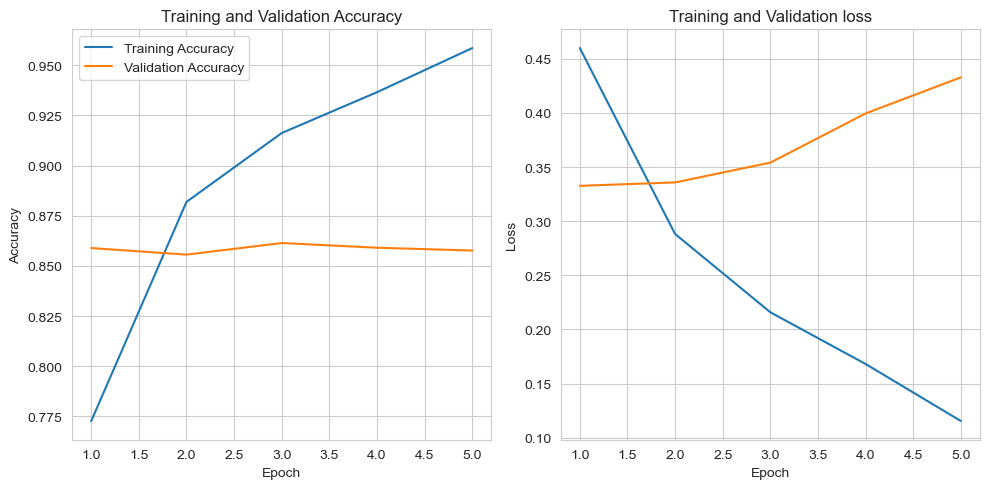

In [61]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)


In [62]:
print("Evaluate Model Performance on Test Set")
result = model.evaluate(pad_test, y_test)

Evaluate Model Performance on Test Set
313/313 [==============================] - 14s 41ms/step - loss: 0.4261 - accuracy: 0.8538


313/313 [==============================] - 13s 38ms/step


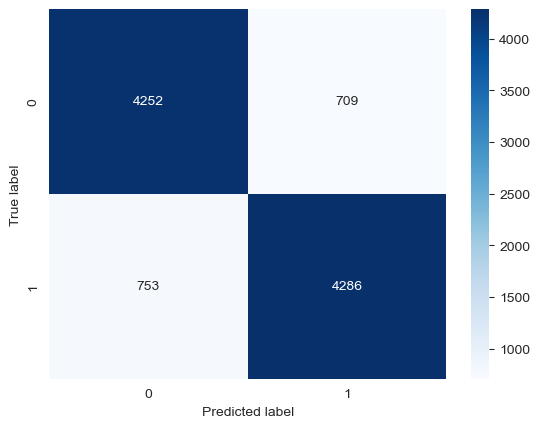

In [63]:
# Confusion Matrix 
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [64]:
from sklearn.metrics import classification_report
print("Classification Report:\n")
print(classification_report(y_test,ypred))

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      4961
           1       0.86      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [67]:
# Preprocess the new text
def preprocess_text(text):
    text = denoise_text(text) 
    return text

# Preprocess the new text instance
new_text_preprocessed = [preprocess_text(text) for text in new_text]

# Tokenize and pad the sequence
seq_new_text = tokenizer.texts_to_sequences(new_text_preprocessed)
pad_new_text = pad_sequences(seq_new_text, truncating='post', padding='pre', maxlen=max_seq_len)

# Make predictions
predictions_new_text = model.predict(pad_new_text)

# Convert predictions to labels (assuming binary classification)
labels_new_text = ['Positive' if pred > 0.5 else 'Negative' for pred in predictions_new_text]

# Print or use the predictions as needed
for text, label in zip(new_text, labels_new_text):
    print(f'Predicted Sentiment: {label}\n')



1/1 [==============================] - 0s 62ms/step
Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Positive

Predicted Sentiment: Negative

Predicted Sentiment: Positive

Predicted Sentiment: Positive

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Positive

Predicted Sentiment: Positive

Predicted Sentiment: Negative

Predicted Sentiment: Positive

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Positive

Predicted Sentiment: Positive

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Positive

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Positive



In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

# Define the Bi-LSTM model
model = Sequential()

# Add an embedding layer
embedding_dim = 64  # Choose an appropriate dimension
model.add(Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=embedding_dim, input_length=max_seq_len))

# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

# Add another Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=32)))

# Add a Dense layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
epochs = 5  # Choose an appropriate number of epochs
batch_size = 32  # Choose an appropriate batch size
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(pad_test, y_test)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 225, 64)           640000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 225, 128)          66048     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 747329 (2.85 MB)
Trainable params: 747329 (2.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
800/800 

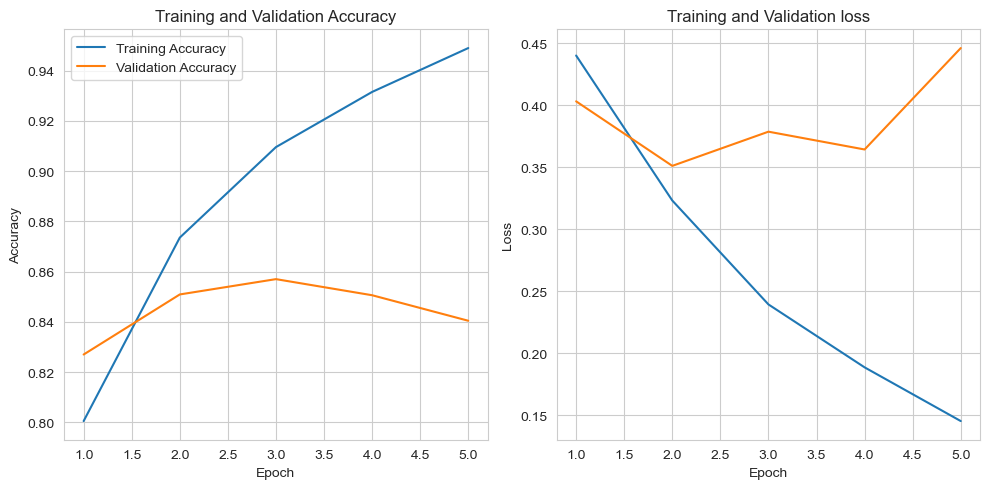

In [73]:
#Plot accuracy and loss
plotLearningCurve(history,epochs)

313/313 [==============================] - 14s 43ms/step


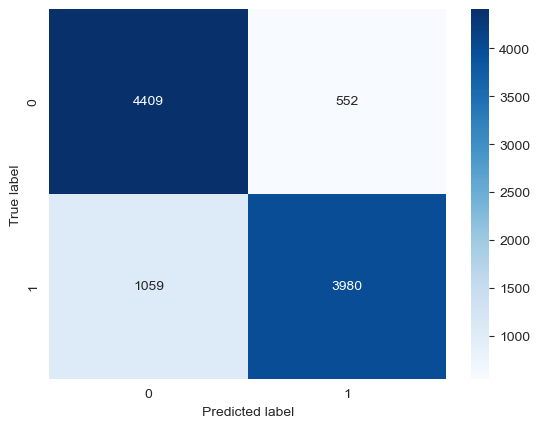

In [74]:
# Confusion Matrix 
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [75]:
from sklearn.metrics import classification_report
print("Classification Report:\n")
print(classification_report(y_test,ypred))

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      4961
           1       0.88      0.79      0.83      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [70]:
# Tokenize and pad the sequence
seq_new_text = tokenizer.texts_to_sequences(new_text_preprocessed)
pad_new_text = pad_sequences(seq_new_text, truncating='post', padding='pre', maxlen=max_seq_len)

# Make predictions
predictions_new_text = model.predict(pad_new_text)

# Convert predictions to labels (assuming binary classification)
labels_new_text = ['Positive' if pred > 0.5 else 'Negative' for pred in predictions_new_text]

# Print or use the predictions as needed
for text, label in zip(new_text, labels_new_text):
    print(f'Predicted Sentiment: {label}\n')

1/1 [==============================] - 1s 1s/step
Predicted Sentiment: Positive

Predicted Sentiment: Positive

Predicted Sentiment: Negative

Predicted Sentiment: Positive

Predicted Sentiment: Positive

Predicted Sentiment: Positive

Predicted Sentiment: Positive

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Positive

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Positive

Predicted Sentiment: Positive

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Positive

Predicted Sentiment: Negative

Predicted Sentiment: Negative

Predicted Sentiment: Negative

